# Regression Model Building

In [1]:
#Import required packages

import re
import pickle
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or svg
%matplotlib inline

sns.set(context='notebook', style='whitegrid', font_scale=.6)

### Bring in Data

In [2]:
#Bring in pickled property and zipcodes dataframe

with open('property_zipcode_merged_df','rb') as read_file:
    property_zipcode_merged_df = pickle.load(read_file)

### Review Data

In [3]:
#Filter out property sales below 10,000 to account for family sales & other outliers

property_zipcode_merged_df = property_zipcode_merged_df[property_zipcode_merged_df['sale_price'] > 10000]

In [49]:
#Add additional columns

#Add to originall control some of the extreness of the taxable dollars target
#Since filtered out below 10,000, no longer needed
property_zipcode_merged_df['taxable_dollars_log'] = property_zipcode_merged_df['percentage_of_taxable_dollars'].apply(math.log)

#Add general_condition columnc
property_zipcode_merged_df['general_condition'] = (property_zipcode_merged_df['exterior_condition']
                                                   *property_zipcode_merged_df['interior_condition'])
#Add years_since last_sale column
def calc_years_since_sale(date_sold):
    years_since = 2021 - date_sold.year
    return years_since

property_zipcode_merged_df['years_since_last_sale'] = (property_zipcode_merged_df['sale_date']
                                                       .apply(calc_years_since_sale))

#Add categorical column for high rated grade school in the zipcode
property_zipcode_merged_df['ave_school_score'] = property_zipcode_merged_df['ave_school_score'].replace(' ','')

def school_sorter(school_score):
    if school_score == 'No Schools':
        value = 'no_school'
    else:
        school_score = int(school_score)
        if school_score >= 8:
            value = 'high'
        elif school_score >= 5:
            value = 'medium'
        elif school_score >= 2:
            value = 'low'
    return value

property_zipcode_merged_df['grade_school_category'] = property_zipcode_merged_df['ave_school_score'].apply(school_sorter)

#Add catergorical variable for different ranges of house sale prices
property_zipcode_merged_df['sale_price_groups'] = pd.cut(property_zipcode_merged_df.sale_price,bins=[0,50000,100000,150000,200000,500000,30000000],labels=['>50k','50-100k','100-150k+','150-200k','200k-500k','500k+'])

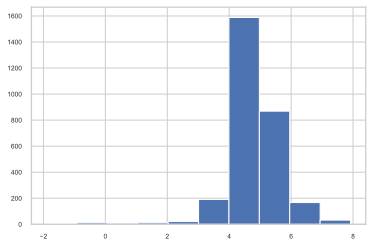

In [50]:
plt.hist(property_zipcode_merged_df['taxable_dollars_log']);

In [6]:
#Create dummies for catergorical variables

#Add dummy variable with zipcodes dummy variable
property_zipcode_merged_df = property_zipcode_merged_df.merge(
    pd.get_dummies(property_zipcode_merged_df['zipcode'],drop_first=True), 
    how='left', left_index=True, right_index=True)

#Add dummy variable with school score variable
property_zipcode_merged_df = property_zipcode_merged_df.merge(
    pd.get_dummies(property_zipcode_merged_df['grade_school_category'],drop_first=True),
    how='left', left_index=True, right_index=True)

#Add dummy variable price of house score variable
property_zipcode_merged_df = property_zipcode_merged_df.merge(
    pd.get_dummies(property_zipcode_merged_df['sale_price_groups'],drop_first=True),
    how='left', left_index=True, right_index=True)


#Add dataframe with neighborhood variable
property_zipcode_merged_df = property_zipcode_merged_df.merge(
    pd.get_dummies(property_zipcode_merged_df['neighborhood'],drop_first=True),
    how='left', left_index=True, right_index=True)

### Run Different Model Options

In [7]:
#Regression function
def test_run_score(features,target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)
    m = LinearRegression()
    m.fit(X_train,y_train)
    print(m.intercept_)
    print(m.coef_)
    return print('Training Set R2:', m.score(X_train,y_train),'Test Set R2:', m.score(X_test,y_test))

In [8]:
#Model 1
target1 = property_zipcode_merged_df['percentage_of_taxable_dollars']
features1 = property_zipcode_merged_df[['number_of_bathrooms', 'number_of_bedrooms','interior_condition', 'exterior_condition', 'percent_female_2016', 'walkscore']]
test_run_score(features1,target1)

312.90070879908393
[-13.06084618  -4.48443601 -25.32686958  52.55543851  -4.04821212
  -0.12626324]
Training Set R2: 0.015450735723533837 Test Set R2: 0.008342510546962334


In [9]:
#Model 2
target2 = property_zipcode_merged_df['percentage_of_taxable_dollars']
features2 = property_zipcode_merged_df[['number_of_bathrooms', 'number_of_bedrooms','exterior_condition', 'percent_female_2016', 'walkscore']]
test_run_score(features2,target2)

309.4896844101093
[-12.84520562  -4.53508162  27.48551076  -4.0056659   -0.12407217]
Training Set R2: 0.015221179144419117 Test Set R2: 0.009830636316273011


In [10]:
#Model 3
property_zipcode_merged_df['walkscore_log'] = property_zipcode_merged_df['walkscore']**2

target3 = property_zipcode_merged_df['percentage_of_taxable_dollars']
features3 = property_zipcode_merged_df[['number_of_bathrooms', 'number_of_bedrooms','exterior_condition', 'percent_female_2016', 'walkscore_log']]
test_run_score(features3,target3)

300.8422964572263
[-1.29027426e+01 -4.59278367e+00  2.76964334e+01 -3.99765027e+00
 -3.31093916e-04]
Training Set R2: 0.015160125527703516 Test Set R2: 0.0096617248812364


In [12]:
#Model 4
target4 = property_zipcode_merged_df['taxable_dollars_log']
features4 = property_zipcode_merged_df[['number_of_bathrooms', 'number_of_bedrooms','exterior_condition',
                                         'walkscore', '19103', '19104', '19106', 
                           '19107', '19111', '19114', '19115', '19116', '19118', '19119', '19120',
                           '19121', '19122', '19123', '19124', '19125', '19126', '19127', '19128',
                           '19129', '19130', '19131', '19132', '19133', '19134', '19135', '19136',
                           '19137', '19138', '19139', '19140', '19141', '19142', '19143', '19144',
                           '19145', '19146', '19147', '19148', '19149', '19150', '19151', '19152',
                           '19153', '19154']]
test_run_score(features4,target4)

21066437859128.266
[-2.20263836e+01 -3.23515278e+00  3.17259757e+01 -2.12792302e+11
 -2.12792302e+11 -2.34071532e+12 -4.25584603e+11  2.76890024e+01
 -6.59656135e+12 -1.08524074e+13 -1.04268228e+13 -1.10651997e+13
 -7.44773056e+12 -5.53259984e+12 -4.25584603e+12 -3.83026143e+12
 -2.55350762e+12 -1.48954611e+12 -3.83026143e+12 -1.70233841e+12
 -5.10701524e+12 -3.83026143e+12 -8.08610746e+12 -5.31980754e+12
 -1.91513071e+12 -5.74539214e+12 -3.40467683e+12 -1.91513071e+12
 -2.12792302e+12 -3.40467683e+12 -7.66052286e+12 -6.59656135e+12
 -3.83026143e+12 -2.34071532e+12 -2.97909222e+12 -2.97909222e+12
 -3.61746913e+12 -3.19188452e+12 -4.25584603e+12 -2.97909222e+12
 -1.91513071e+12 -6.38376905e+11 -1.48954611e+12 -3.19188452e+12
 -5.95818444e+12 -4.25584603e+12 -7.66052286e+12 -8.93727667e+12
 -1.19163689e+13]
Training Set R2: 0.06141391227837689 Test Set R2: 0.018666282550342417


In [14]:
#Model 5
target5 = property_zipcode_merged_df['taxable_dollars_log']
features5 = property_zipcode_merged_df[['number_of_bathrooms', 'number_of_bedrooms','exterior_condition', 
                                        'walkscore', 'low', 'medium', 'no_school']]
test_run_score(features5,target5)

38.879883579576074
[-13.73417036  -3.39479934  27.70887259   0.07285345  39.33931706
  66.70382038  23.90085569]
Training Set R2: 0.01792576011677649 Test Set R2: 0.012288660729432466


In [16]:
#Model 6
target6 = property_zipcode_merged_df['taxable_dollars_log']
features6 = property_zipcode_merged_df[['number_of_bathrooms', 'number_of_bedrooms','interior_condition', 'exterior_condition', 'percent_female_2016', 'walkscore']]

test_run_score(features6,target6)

312.90070879908393
[-13.06084618  -4.48443601 -25.32686958  52.55543851  -4.04821212
  -0.12626324]
Training Set R2: 0.015450735723533837 Test Set R2: 0.008342510546962334


In [18]:
#Model 7
target7 = property_zipcode_merged_df['taxable_dollars_log']
features7 = property_zipcode_merged_df[['number_of_bathrooms', 'number_of_bedrooms','interior_condition',
                                        'exterior_condition', 'percent_female_2016', 'walkscore', '19103', '19104', '19106', 
                                        '19107', '19111', '19114', '19115', '19116', '19118', '19119', '19120',
                                        '19121', '19122', '19123', '19124', '19125', '19126', '19127', '19128',
                                        '19129', '19130', '19131', '19132', '19133', '19134', '19135', '19136',
                                        '19137', '19138', '19139', '19140', '19141', '19142', '19143', '19144',
                                        '19145', '19146', '19147', '19148', '19149', '19150', '19151', '19152',
                                        '19153', '19154']]
test_run_score(features7,target7)

168686791580306.12
[-2.21824273e+01 -3.20687708e+00 -1.53162618e+01  4.69236391e+01
 -2.25934107e+12 -5.79485423e+11  1.46484734e+13 -5.80950438e+12
 -1.29453131e+12  3.16307750e+12 -1.29934977e+13 -2.38602171e+13
 -2.02159710e+13 -2.19770207e+13 -6.22888831e+12 -5.46442142e+12
 -5.57986120e+12  2.80900109e+12 -4.53633012e+12  2.51828457e+12
  4.36692959e+11 -6.30779578e+12 -2.27204361e+12 -2.04396186e+13
 -1.60783790e+13 -7.86726622e+12 -6.02873159e+12  1.41191870e+12
  2.40902659e+12  3.12159976e+12 -8.92084096e+11 -3.62341408e+12
 -2.12907500e+13 -1.81899822e+13  6.83062820e+12  1.03221909e+13
 -1.15402541e+12  4.76544821e+12 -5.42766960e+11  2.64961085e+12
 -4.96343779e+11 -1.28958587e+12  4.72573192e+12  1.33424759e+12
 -2.74598014e+12 -2.88577478e+12  3.12784828e+11  4.83570116e+12
 -1.52809028e+13 -1.65436610e+13 -2.80002818e+13]
Training Set R2: 0.061502685560626214 Test Set R2: 0.017621954135867313


In [19]:
#Model 8
target8 = property_zipcode_merged_df['taxable_dollars_log']
features8 = property_zipcode_merged_df[['number_of_rooms', 'general_condition', 'walkscore']]

test_run_score(features8,target8)

154.64850487357535
[-3.89437267  3.2862134  -0.17981954]
Training Set R2: 0.007955726373998773 Test Set R2: 0.005968662239491773


In [20]:
#Model 9
target9 = property_zipcode_merged_df['taxable_dollars_log']
features9 = property_zipcode_merged_df[['number_of_rooms', 'general_condition', 'walkscore', 'years_since_last_sale',
                                         'walkscore', 'low', 'medium', 'no_school']]

test_run_score(features9,target9)

-16.562993611216285
[-1.46664853e+00 -4.36590198e-01  8.07935775e+13  8.96898962e+00
 -8.07935775e+13  8.72683790e+00  3.83230220e+01 -2.90365956e+00]
Training Set R2: 0.2854701621846074 Test Set R2: 0.3441972748107823


In [22]:
#Model 10 - Move forward for cross validation
target10 = property_zipcode_merged_df['taxable_dollars_log']
features10 = property_zipcode_merged_df[['number_of_rooms', 'general_condition', 'walkscore', 'years_since_last_sale']]

test_run_score(features10,target10)

5.3540739375918065
[-2.65237494 -0.56938081  0.71916124  8.96600304]
Training Set R2: 0.2815098999072938 Test Set R2: 0.342399112454829


In [24]:
#Model 11
target11 = property_zipcode_merged_df['taxable_dollars_log']
features11 = property_zipcode_merged_df[['number_of_rooms', 'general_condition', 'years_since_last_sale',
                                         'walkscore', 'low', 'medium', 'no_school']]

test_run_score(features11,target11)

-31.1941348493082
[-1.54641412 -0.33184223  8.96186356  0.91452166  8.70687137 38.24402239
 -2.87944808]
Training Set R2: 0.2853979570198917 Test Set R2: 0.343734701105731


In [27]:
#Model 12
target12 = property_zipcode_merged_df['percentage_of_taxable_dollars']
features12 = property_zipcode_merged_df[['number_of_rooms', 'general_condition', 'years_since_last_sale', 'walkscore',
                                         '50-100k', '100-150k+', '150-200k', '200k-500k', '500k+']]

test_run_score(features12,target12)

279.5873891310476
[-6.11767595e+00 -4.20446363e+00  6.54273488e+00 -1.12859022e-01
 -1.29735380e+02 -1.40622650e+02 -1.51829530e+02 -1.56016499e+02
 -1.87513225e+02]
Training Set R2: 0.3614484337967304 Test Set R2: 0.45373357159110517


In [30]:
#Model 13

#Add polynomial variable due to shape of trend
property_zipcode_merged_df['years_since_last_sale_sq'] = property_zipcode_merged_df['years_since_last_sale']**2

target13 = property_zipcode_merged_df['percentage_of_taxable_dollars']
features13 = property_zipcode_merged_df[['number_of_rooms', 'general_condition', 'years_since_last_sale_sq', 'walkscore',
                                         '50-100k', '100-150k+', '200k-500k', '500k+']]

test_run_score(features13,target13)

138.86919505760616
[  -4.08804527   -2.61822869    0.1897329     0.93703271  -66.80722777
  -76.82145222  -92.17524634 -133.25096047]
Training Set R2: 0.38438833514345483 Test Set R2: 0.4865063549821069


In [32]:
#Model 14 - Move forward for cross validation

property_zipcode_merged_df['years_since_last_sale_cube'] = property_zipcode_merged_df['years_since_last_sale']**3

target14 = property_zipcode_merged_df['percentage_of_taxable_dollars']
features14 = property_zipcode_merged_df[['number_of_rooms', 'general_condition','years_since_last_sale_cube',
                                         '50-100k', '100-150k+', '150-200k',  '200k-500k', '500k+']]

test_run_score(features14,target14)

320.8514413229941
[-6.19765128e+00 -3.85784748e+00  3.25185029e-03 -1.08605247e+02
 -1.37780583e+02 -1.52150205e+02 -1.65521863e+02 -1.96294805e+02]
Training Set R2: 0.4244521034670591 Test Set R2: 0.5524983003779464


In [58]:
#Model 15 - Move forward for cross validation

target15 = property_zipcode_merged_df['percentage_of_taxable_dollars']
features15 = property_zipcode_merged_df[['number_of_rooms', 'general_condition','50-100k', '100-150k+', '150-200k', '200k-500k', '500k+', 
                                         'far_northeast_philly', 'years_since_last_sale_cube',
                                         'kensington_fishtown','lower_north_philly',
                                         'near_northeast_philly', 'olney_oak_lane','roxborough_manayunk', 'south_philly',
                                         'southwest_philly', 'upper_northwest', 'west_philly']]

test_run_score(features15,target15)

392.31098644989004
[-4.70920040e+00 -3.78102493e+00 -1.11455193e+02 -1.46548887e+02
 -1.69878216e+02 -2.04861741e+02 -2.49530756e+02 -4.38762708e+01
  3.12358460e-03 -5.17432248e+01 -7.70819372e+01 -9.02949253e+01
 -1.16917733e+02 -3.26703851e+01 -8.61454814e+00 -1.06604684e+02
 -3.98644661e+01 -1.02620499e+02]
Training Set R2: 0.4537918644329443 Test Set R2: 0.5767745598099749


### Review Correlations with Variables Included in Models Moving to Cross Validation

In [34]:
property_zipcode_merged_df[['number_of_rooms', 'general_condition','50-100k', '100-150k+', '150-200k', '200k-500k', '500k+', 
                                         'far_northeast_philly', 'years_since_last_sale_cube',
                                         'kensington_fishtown','lower_north_philly',
                                         'near_northeast_philly', 'olney_oak_lane','roxborough_manayunk', 'south_philly',
                                         'southwest_philly', 'upper_northwest', 'west_philly']].corr()

number_of_rooms  general_condition   50-100k  \
number_of_rooms                    1.000000           0.012203  0.043693   
general_condition                  0.012203           1.000000  0.105547   
50-100k                            0.043693           0.105547  1.000000   
100-150k+                          0.008491           0.018921 -0.228547   
150-200k                          -0.059079          -0.010475 -0.196749   
200k-500k                         -0.114668          -0.283424 -0.267539   
500k+                             -0.103673          -0.184635 -0.130234   
far_northeast_philly              -0.262794           0.064695 -0.031229   
years_since_last_sale_cube        -0.037682           0.099015 -0.029917   
kensington_fishtown                0.066133          -0.039281 -0.046343   
lower_north_philly                 0.032125          -0.049788 -0.065261   
near_northeast_philly              0.068632           0.082284  0.152418   
olney_oak_lane                     0.143590           0.054584  0.066146   
roxborough_manayunk                0.102919          -0.066644 -0.048493   
south_philly                       0.102035          -0.008741 -0.015373   
southwest_philly                   0.059787           0.059212 -0.003328   
upper_northwest                    0.073506           0.010600 -0.016504   
west_philly                       -0.009848           0.042215  0.054648   

                            100-150k+  150-200k  200k-500k     500k+  \
number_of_rooms              0.008491 -0.059079  -0.114668 -0.103673   
general_condition            0.018921 -0.010475  -0.283424 -0.184635   
50-100k                     -0.228547 -0.196749  -0.267539 -0.130234   
100-150k+                    1.000000 -0.138373  -0.188159 -0.091593   
150-200k                    -0.138373  1.000000  -0.161980 -0.078850   
200k-500k                   -0.188159 -0.161980   1.000000 -0.107220   
500k+                       -0.091593 -0.078850  -0.107220  1.000000   
far_northeast_philly         0.038032  0.148794   0.098527 -0.096043   
years_since_last_sale_cube  -0.101712 -0.111667  -0.168635 -0.078551   
kensington_fishtown         -0.034318 -0.025899   0.016452 -0.016674   
lower_north_philly          -0.056033 -0.056736   0.009701 -0.003257   
near_northeast_philly        0.128491  0.036564  -0.158011 -0.095144   
olney_oak_lane               0.027813 -0.057641  -0.149263 -0.077257   
roxborough_manayunk         -0.034279  0.057587   0.155605 -0.013167   
south_philly                 0.033129 -0.002428   0.023179 -0.051928   
southwest_philly            -0.042115 -0.036552  -0.078154 -0.024560   
upper_northwest             -0.027529 -0.002516   0.014630  0.084492   
west_philly                 -0.020187 -0.033958  -0.076642 -0.031083   

                            far_northeast_philly  years_since_last_sale_cube  \
number_of_rooms                        -0.262794                   -0.037682   
general_condition                       0.064695                    0.099015   
50-100k                                -0.031229                   -0.029917   
100-150k+                               0.038032                   -0.101712   
150-200k                                0.148794                   -0.111667   
200k-500k                               0.098527                   -0.168635   
500k+                                  -0.096043                   -0.078551   
far_northeast_philly                    1.000000                    0.151814   
years_since_last_sale_cube              0.151814                    1.000000   
kensington_fishtown                    -0.119491                   -0.029071   
lower_north_philly                     -0.124188                   -0.051860   
near_northeast_philly                  -0.190604                   -0.027795   
olney_oak_lane                         -0.151326                    0.036567   
roxborough_manayunk                    -0.084605                   -0.032327   
south_philly  

### Cross Valiation

In [35]:
#Model 14
m = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
print('Linear Regression: ', cross_val_score(m, features14, target14, cv=kf, scoring='r2'), 'Mean: ', cross_val_score(m, features14, target14, cv=kf, scoring='r2').mean())

Linear Regression:  [0.31074959 0.57313776 0.50668324 0.40913554 0.45193919] Mean:  0.4503290626724416


In [59]:
#Model 15 - Select this model!
m = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
print('Linear Regression: ', cross_val_score(m, features15, target15, cv=kf, scoring='r2'), 'Mean: ', cross_val_score(m, features15, target15, cv=kf, scoring='r2').mean())

Linear Regression:  [0.35141767 0.59786267 0.49222106 0.43720664 0.48252884] Mean:  0.4722473760956653


### Final Model Testing

In [60]:
#Create OLS model to review additional statistics on final model selection
model = sm.OLS(target15, sm.add_constant(features15)) 

#Fit
fit = model.fit()

#Print out summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     percentage_of_taxable_dollars   R-squared:                       0.490
Model:                                       OLS   Adj. R-squared:                  0.486
Method:                            Least Squares   F-statistic:                     153.7
Date:                           Fri, 14 May 2021   Prob (F-statistic):               0.00
Time:                                   06:57:02   Log-Likelihood:                -18418.
No. Observations:                           2903   AIC:                         3.687e+04
Df Residuals:                               2884   BIC:                         3.699e+04
Df Model:                                     18                                         
Covariance Type:                       nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        377.2819     15.937     23.674      0.000     346.033     408.530
number_of_rooms               -4.0320      1.017     -3.966      0.000      -6.025      -2.039
general_condition             -3.2739      0.679     -4.820      0.000      -4.606      -1.942
50-100k                     -113.3770      7.630    -14.859      0.000    -128.338     -98.416
100-150k+                   -146.4458      9.220    -15.884      0.000    -164.524    -128.368
150-200k                    -169.5882     10.310    -16.450      0.000    -189.803    -149.373
200k-500k                   -201.2928      9.555    -21.066      0.000    -220.029    -182.557
500k+                       -244.0432     14.481    -16.853      0.000    -272.437    -215.649
far_northeast_philly         -43.0305     11.376     -3.783      0.000     -65.336     -20.725
years_since_last_sale_cube     0.0034      0.000     30.950      0.000       0.003       0.004
kensington_fishtown          -54.3502     13.240     -4.105      0.000     -80.312     -28.388
lower_north_philly           -76.0131     12.999     -5.848      0.000    -101.501     -50.526
near_northeast_philly        -84.7605     11.641     -7.281      0.000    -107.585     -61.936
olney_oak_lane              -112.8811     12.597     -8.961      0.000    -137.580     -88.182
roxborough_manayunk          -21.9688     16.033     -1.370      0.171     -53.407       9.469
south_philly                  -7.6221     13.460     -0.566      0.571     -34.013      18.769
southwest_philly            -102.2835     13.795     -7.415      0.000    -129.332     -75.235
upper_northwest              -45.2755     14.894     -3.040      0.002     -74.479     -16.072
west_philly                  -93.8793     13.204     -7.110      0.000    -119.769     -67.989
==============================================================================
Omnibus:                     3054.520   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           483977.766
Skew:                           4.865   Prob(JB):                         0.00
Kurtosis:                      65.502   Cond. No.                     3.70e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [70]:
X_train, X_test, y_train, y_test = train_test_split(features15, target15, test_size=0.2, random_state=2)
final_model = LinearRegression()
final_model.fit(X_train,y_train)
print(final_model.intercept_)
print(list(zip(final_model.coef_, features15)))
print('Training Set R2:', final_model.score(X_train,y_train),'Test Set R2:', final_model.score(X_test,y_test))

358.27691313025025
[(-3.7604268837333685, 'number_of_rooms'), (-3.6606709984897976, 'general_condition'), (-110.53727248810297, '50-100k'), (-145.34413233878996, '100-150k+'), (-168.31745041469478, '150-200k'), (-196.8495156523525, '200k-500k'), (-229.98508078658466, '500k+'), (-18.99496425657245, 'far_northeast_philly'), (0.0031386048022499224, 'years_since_last_sale_cube'), (-36.116736459049726, 'kensington_fishtown'), (-49.54363020108464, 'lower_north_philly'), (-61.36388521239906, 'near_northeast_philly'), (-87.40404310808391, 'olney_oak_lane'), (1.498177308003623, 'roxborough_manayunk'), (14.588219031876152, 'south_philly'), (-75.60480590625191, 'southwest_philly'), (-22.43999892277939, 'upper_northwest'), (-70.37274816770338, 'west_philly')]
Training Set R2: 0.5013458869430226 Test Set R2: 0.45092365165309944


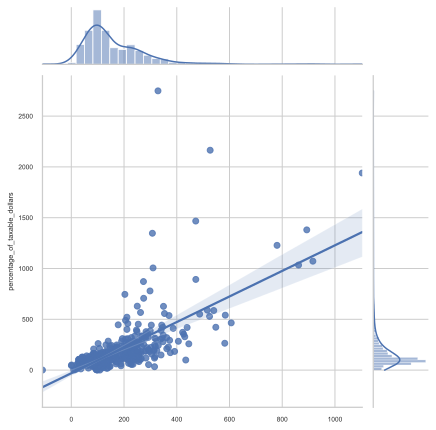

In [69]:
#Select 16 and move forward with residuals
preds = final_model.predict(X_test)
residuals = y_test - preds
sns.jointplot(x=preds,y=y_test, kind='reg')

In [71]:
#Look at AME & RSME
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(mean_squared_error(y_test, preds, squared=False))
print(np.sqrt(mean_squared_error(y_test, preds, squared=False)))
print(mean_absolute_error(y_test, preds))

169.6838499469322
13.026275367384654
69.69410307047353


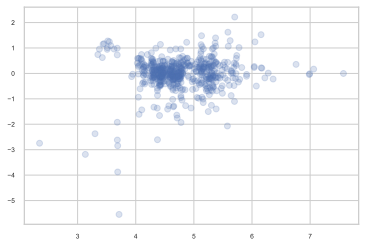

In [57]:
#Check residuals
plt.scatter(x=preds,y=residuals,alpha=0.2)